In [1]:
import xarray as xr
import numpy as np
import xgcm
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 16

from bbl_utils import *

import warnings
warnings.filterwarnings('ignore', '.*.')

div_cmap = plt.get_cmap('RdBu_r')
div_cmap.set_bad(color=(0.8,0.8,0.8))

cmap = plt.get_cmap('viridis')
cmap.set_bad(color=(0.8,0.8,0.8))

In [2]:
iters=np.arange(720, 720*21, 720)

### Physical parameters

In [3]:
Γ = 0.0008613659531090722
θ = 1.53E-3
f = -0.53e-4

### Test grid pre-processing

In [4]:
data_dir_2D = f"../../MITgcm/experiments/rotated_BBTRE_2D_kappa_kh_test/run/"
ds = open_mdsdataset(data_dir_2D,iters=iters,ignore_unknown_vars=True,prefix=["standardDiag", "budgetDiag", "tracer01Diag", "tracer02Diag"])

In [64]:
H = ds['Depth'].max().values.copy().astype('>f8')
ds['Z'] += H
ds['Zl'] += H
ds['Zu'] += H
ds['Zp1'] += H

grid = Grid(ds, periodic=['X', 'Y'])

ds = ds.assign_coords({
    'Zr': (['XC', 'Z'], (ds['XC']*np.sin(θ) + ds['Z']*np.cos(θ)).values),
    'Xr': (['XC', 'Z'], (ds['XC']*np.cos(θ) - ds['Z']*np.sin(θ)).values),
    'Zr_V': (['XC', 'Z'], (ds['XC']*np.sin(θ) + ds['Z']*np.cos(θ)).values),
    'Xr_V': (['XC', 'Z'], (ds['XC']*np.cos(θ) - ds['Z']*np.sin(θ)).values),
    'Zr_U': (['XG', 'Z'], (ds['XG']*np.sin(θ) + ds['Z']*np.cos(θ)).values),
    'Xr_U': (['XG', 'Z'], (ds['XG']*np.cos(θ) - ds['Z']*np.sin(θ)).values),
    'Zr_W': (['XC', 'Zl'], (ds['XC']*np.sin(θ) + ds['Zl']*np.cos(θ)).values),
    'Xr_W': (['XC', 'Zl'], (ds['XC']*np.cos(θ) - ds['Zl']*np.sin(θ)).values)
})

ds['Depthr'] = ds['Depth'] - ds['XC']*np.tan(θ)

\begin{equation}
\int \partial_{t}  \left( \Theta c \right) \text{d}V + \int \left( c \nabla \cdot \mathbf{u} \Theta + \Theta \nabla \cdot \mathbf{u} c \right) \text{d}V = \int \left( c \nabla \cdot \mathbf{F_{\Theta}} + \Theta \nabla \cdot \mathbf{F_{c}} \right) \text{d}V
\end{equation}


We decompose $\Theta = \overline{\Theta} + \Theta'$ where $\partial_{z} \overline{\Theta} = \Gamma$ is a constant lapse rate.

\begin{equation}
\int \left( \left( \overline{\Theta} + \Theta' \right) \partial_{t} c + c \partial_{t} \Theta' \right) \text{d}V +
\int \left( c \nabla \cdot \mathbf{u} \Theta' + cw \Gamma + (\overline{\Theta} + \Theta') \nabla \cdot \mathbf{u} c \right) \text{d}V =
\int \left( c \nabla \cdot \mathbf{F_{\Theta'}} - c \partial_{z} ( \kappa \Gamma) + (\overline{\Theta} + \Theta') \nabla \cdot \mathbf{F_{c}} \right) \text{d}V
\end{equation}

In [74]:
def tracer_flux_budget(suffix):
    """Calculate the convergence of fluxes of tracer `suffix` where
    `suffix` is `_TH`, `Tr01`, or 'Tr02'. Return a new xarray.Dataset."""
    conv_horiz_adv_flux = -(grid.diff(dsr['ADVx' + suffix], 'X') +
                          grid.diff(dsr['ADVy' + suffix], 'Y')).rename('conv_horiz_adv_flux' + suffix)
    conv_horiz_diff_flux = -(grid.diff(dsr['DFxE' + suffix], 'X') +
                          grid.diff(dsr['DFyE' + suffix], 'Y')).rename('conv_horiz_diff_flux' + suffix)
    # sign convention is opposite for vertical fluxes
    conv_vert_adv_flux = grid.diff(dsr['ADVr' + suffix], 'Z', boundary='fill').rename('conv_vert_adv_flux' + suffix)
    conv_vert_diff_flux = grid.diff(dsr['DFrE' + suffix], 'Z', boundary='fill').rename('conv_vert_diff_flux' + suffix)

    all_fluxes = [conv_horiz_adv_flux, conv_horiz_diff_flux, conv_vert_adv_flux, conv_vert_diff_flux]
    conv_all_fluxes = sum(all_fluxes).rename('conv_total_flux' + suffix)

    return xr.merge(all_fluxes + [conv_all_fluxes])

### Closing the temperature budget

### Closing the injected tracer budget

### Tracer-weighted density (first moment)

In [ ]:
ds['cθ'] = ds['TRAC01']*ds['THETA']

ds['div_uθ'] = (
    grid.diff(ds['ADVx_TH'], 'X')
)
ds['div_uθ'] = (
    ds['ADVxTr01']
)

ds['c_div_uθ'] = ds['TRAC01'] * 
ds['θ_div_uc'] = 0.
ds['c_div_θflux'] = 0.
ds['θ_div_cflux'] = 0.

In [66]:
grid.diff(ds['ADVx_TH'], 'X') + grid.diff(ds['ADVr_TH'], 'Z', boundary='fill')

<xarray.DataArray (time: 20, Z: 260, YC: 1, XC: 800)>
dask.array<add, shape=(20, 260, 1, 800), dtype=float64, chunksize=(1, 259, 1, 799), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) timedelta64[ns] 00:12:00 00:24:00 ... 03:48:00 04:00:00
  * Z        (Z) >f8 3.25e+03 3.179e+03 3.111e+03 3.044e+03 ... 7.5 2.5 -2.5
  * YC       (YC) >f8 250.0
  * XC       (XC) >f8 250.0 750.0 1.25e+03 ... 3.988e+05 3.992e+05 3.998e+05

### Load dataset

In [5]:
kappa_list = [1]
ds_list = []
coords_list = []
grid_list = []

for kappa in kappa_list:
    data_dir_2D = f"../../MITgcm/experiments/rotated_BBTRE_2D_kappa_kh_test/run/"
    ds_2D = open_mdsdataset(data_dir_2D,iters=iters,ignore_unknown_vars=True,prefix=["standardDiag", "budgetDiag", "tracer01Diag", "tracer02Diag"])
    ds_2D, coords_2D, grid_2D = pre_process(ds_2D)
    ds_2D, coords_2D = add_cartesian_coordinates(ds_2D, coords_2D, θ)
    ds_2D = add_background_temp(ds_2D, Γ)
    ds_2D, coords_2D = add_hab_coordinates(ds_2D, coords_2D)
    ds_2D = add_Nsq(ds_2D, Γ)
    
    ds_list.append(ds_2D)
    coords_list.append(coords_2D)
    grid_list.append(grid_2D)

In [6]:
ds = ds_list[0]
coords = coords_list[0]
grid = grid_list[0]
ds

<xarray.Dataset>
Dimensions:   (XC: 800, XG: 800, YC: 1, YG: 1, Z: 260, Zl: 260, Zp1: 261, Zu: 260, time: 20)
Coordinates:
  * time      (time) float64 720.0 1.44e+03 2.16e+03 ... 1.368e+04 1.44e+04
  * XC        (XC) >f8 250.0 750.0 1.25e+03 ... 3.988e+05 3.992e+05 3.998e+05
  * YC        (YC) >f8 250.0
  * XG        (XG) >f8 0.0 500.0 1e+03 1.5e+03 ... 3.985e+05 3.99e+05 3.995e+05
  * YG        (YG) >f8 0.0
  * Z         (Z) float64 3.25e+03 3.179e+03 3.111e+03 ... 7.5 2.5 -2.5
  * Zp1       (Zp1) float64 3.285e+03 3.214e+03 3.144e+03 ... -1.364e-12 -5.0
  * Zu        (Zu) float64 3.214e+03 3.144e+03 3.077e+03 ... 5.0 -1.364e-12 -5.0
  * Zl        (Zl) float64 3.285e+03 3.214e+03 3.144e+03 ... 10.0 5.0 -1.364e-12
    Zr        (XC, Z) float64 3.25e+03 3.18e+03 3.111e+03 ... 619.1 614.1 609.1
    Xr        (XC, Z) float64 245.0 245.1 245.2 ... 3.997e+05 3.997e+05
    Zr_V      (XC, Z) float64 3.25e+03 3.18e+03 3.111e+03 ... 619.1 614.1 609.1
    Xr_V      (XC, Z) float64 245.0 245.1 245.2 ... 3.997e+05 3.997e+05
    Zr_U      (XG, Z) float64 3.25e+03 3.179e+03 3.111e+03 ... 618.7 613.7 608.7
    Xr_U      (XG, Z) float64 -4.972 -4.864 -4.759 ... 3.995e+05 3.995e+05
    Zr_W      (XC, Zl) float64 3.286e+03 3.214e+03 3.145e+03 ... 616.6 611.6
    Xr_W      (XC, Zl) float64 245.0 245.1 245.2 ... 3.997e+05 3.997e+05
    Z_hab     (Z, YC, XC) float64 dask.array<chunksize=(260, 1, 800), meta=np.ndarray>
    Zl_hab    (Zl, YC, XC) float64 dask.array<chunksize=(260, 1, 800), meta=np.ndarray>
Data variables:
    gT_Forc   (time, Z, YC, XC) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    ADVr_TH   (time, Zl, YC, XC) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    ADVx_TH   (time, Z, YC, XG) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    ADVy_TH   (time, Z, YG, XC) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    DFrI_TH   (time, Zl, YC, XC) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    DFxE_TH   (time, Z, YC, XG) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    DFyE_TH   (time, Z, YG, XC) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    TOTTTEND  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    TOTUTEND  (time, Z, YC, XG) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    TOTVTEND  (time, Z, YG, XC) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    KVDIFF    (time, Zl, YC, XC) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    TRAC02    (time, Z, YC, XC) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    ForcTr02  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    DFrETr02  (time, Zl, YC, XC) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    DFxETr02  (time, Z, YC, XG) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    DFyETr02  (time, Z, YG, XC) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    ADVrTr02  (time, Zl, YC, XC) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    ADVxTr02  (time, Z, YC, XG) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    ADVyTr02  (time, Z, YG, XC) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    THETA     (time, Z, YC, XC) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    UVEL      (time, Z, YC, XG) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    VVEL      (time, Z, YG, XC) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    WVEL      (time, Zl, YC, XC) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    DRHODR    (time, Zl, YC, XC) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    TRAC01    (time, Z, YC, XC) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    ForcTr01  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 26

In [7]:
ds['TRAC01'] = ds['TRAC01'].where(coords['hFacC'] != 0.).compute()
ds['TRAC02'] = ds['TRAC02'].where(coords['hFacC'] != 0.).compute()

In [8]:
ds.data_vars

Data variables:
    gT_Forc   (time, Z, YC, XC) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    ADVr_TH   (time, Zl, YC, XC) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    ADVx_TH   (time, Z, YC, XG) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    ADVy_TH   (time, Z, YG, XC) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    DFrI_TH   (time, Zl, YC, XC) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    DFxE_TH   (time, Z, YC, XG) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    DFyE_TH   (time, Z, YG, XC) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    TOTTTEND  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    TOTUTEND  (time, Z, YC, XG) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    TOTVTEND  (time, Z, YG, XC) float64 dask.array<chunksize=(1, 260, 1, 800), meta=np.ndarray>
    KVDIFF    (time, Z

### Confirming that tracer moment budgets close

\begin{equation}
\int \partial_{t}  \left( \Theta c \right) \text{d}V + \int \left( c \nabla \cdot \mathbf{u} \Theta + \Theta \nabla \cdot \mathbf{u} c \right) \text{d}V = \int \left( c \nabla \cdot \mathbf{F_{\Theta}} + \Theta \nabla \cdot \mathbf{F_{c}} \right) \text{d}V
\end{equation}


In [9]:
grid.diff(ds['ADVx_TH'], 'X')

<xarray.DataArray 'sub-a22ebef8934f825f8e98afc40f0ad293' (time: 20, Z: 260, YC: 1, XC: 800)>
dask.array<sub, shape=(20, 260, 1, 800), dtype=float64, chunksize=(1, 260, 1, 799), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 720.0 1.44e+03 2.16e+03 ... 1.368e+04 1.44e+04
  * Z        (Z) float64 3.25e+03 3.179e+03 3.111e+03 3.044e+03 ... 7.5 2.5 -2.5
  * YC       (YC) >f8 250.0
  * XC       (XC) >f8 250.0 750.0 1.25e+03 ... 3.988e+05 3.992e+05 3.998e+05

In [12]:
ds['ADVr_TH']

<xarray.DataArray 'ADVr_TH' (time: 20, Zl: 260, YC: 1, XC: 800)>
dask.array<concatenate, shape=(20, 260, 1, 800), dtype=float64, chunksize=(1, 260, 1, 800), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 720.0 1.44e+03 2.16e+03 ... 1.368e+04 1.44e+04
  * XC       (XC) >f8 250.0 750.0 1.25e+03 ... 3.988e+05 3.992e+05 3.998e+05
  * YC       (YC) >f8 250.0
  * Zl       (Zl) float64 3.285e+03 3.214e+03 3.144e+03 ... 10.0 5.0 -1.364e-12
    Zr_W     (XC, Zl) float64 3.286e+03 3.214e+03 3.145e+03 ... 616.6 611.6
    Xr_W     (XC, Zl) float64 245.0 245.1 245.2 ... 3.997e+05 3.997e+05
    Zl_hab   (Zl, YC, XC) float64 dask.array<chunksize=(260, 1, 800), meta=np.ndarray>
Attributes:
    standard_name:  ADVr_TH
    long_name:      Vertical   Advective Flux of Pot.Temperature
    units:          degC.m^3/s

In [85]:
grid.diff(ds['ADVx_TH'], 'X') + grid.diff(ds['ADVr_TH'], 'Z', boundary='fill')

<xarray.DataArray (time: 19, Z: 0, YC: 1, XC: 800)>
dask.array<add, shape=(19, 0, 1, 800), dtype=float64, chunksize=(1, 0, 1, 799), chunktype=numpy.ndarray>
Coordinates:
  * Z        (Z) float64 
  * time     (time) float64 720.0 1.44e+03 2.16e+03 ... 1.296e+04 1.368e+04
  * YC       (YC) >f8 250.0
  * XC       (XC) >f8 250.0 750.0 1.25e+03 ... 3.988e+05 3.992e+05 3.998e+05

In [21]:
ds['cθ'] = ds['TRAC01']*ds['THETA']

ds['div_uθ'] = (
    grid.diff(ds['ADVx_TH'], 'X')
)
ds['div_uθ'] = (
    ds['ADVxTr01']
)

ds['c_div_uθ'] = ds['TRAC01'] * 
ds['θ_div_uc'] = 0.
ds['c_div_θflux'] = 0.
ds['θ_div_cflux'] = 0.

### Plots of tracer concentration

In [8]:
x1 = 3.e4; x2 = x1; δx = 1.e4;
z1 = 900.
z2 = 100.
δz = 40.;

H = coords['Depth'].max().values.copy().astype('>f8')
seafloor = H - coords['Depth']

C1 = np.exp(- ((ds['XC'] - x1)/δx)**2 - ((ds['Z'] - seafloor.sel(XC=x2, method='nearest') - z1)/δz)**2)
C2 = np.exp(- ((ds['XC'] - x2)/δx)**2 - ((ds['Z'] - seafloor.sel(XC=x1, method='nearest') - z2)/δz)**2)

C1 = C1.where(coords['Z'] - seafloor >= 0)
C2 = C2.where(coords['Z'] - seafloor >= 0)

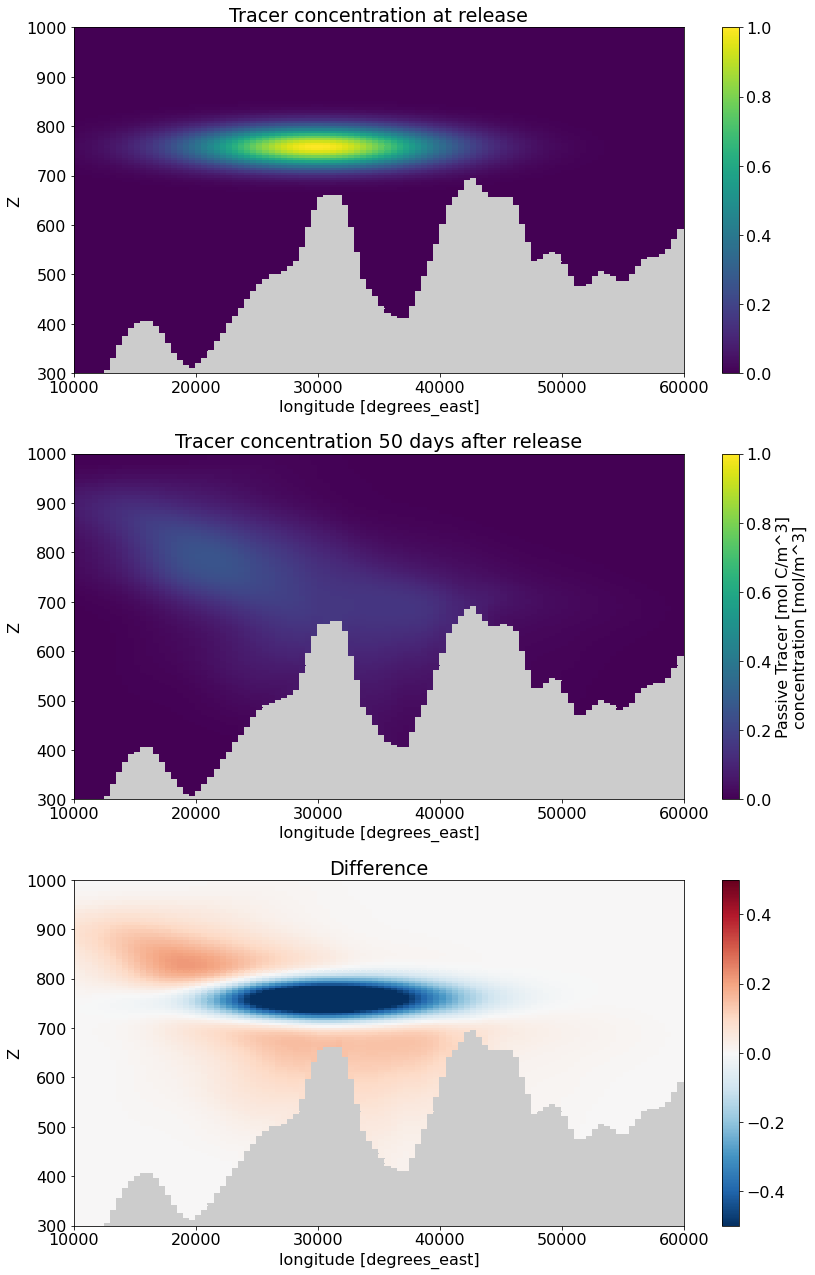

In [9]:
plt.figure(figsize=(12,18))

plt.subplot(3,1,1)
q = (C2).plot(y = 'Z')
plt.xlim([10000, 60000])
plt.ylim([300, 1000])
q.set_clim([0, 1])
plt.title("Tracer concentration at release")

plt.subplot(3,1,2)
q = (ds['TRAC02'].isel(time=-1)).plot(y = 'Z')
plt.xlim([10000, 60000])
plt.ylim([300, 1000])
q.set_clim([0, 1])
plt.title("Tracer concentration 50 days after release")

plt.subplot(3,1,3)
q = (ds['TRAC02'].isel(time=-1) - C2).plot(y = 'Z')
plt.xlim([10000, 60000])
plt.ylim([300, 1000])
q.set_clim([-0.5, 0.5])
plt.title("Difference")

plt.tight_layout()

Text(0.5, 1.0, 'Tracer concentration 1000 days after release')

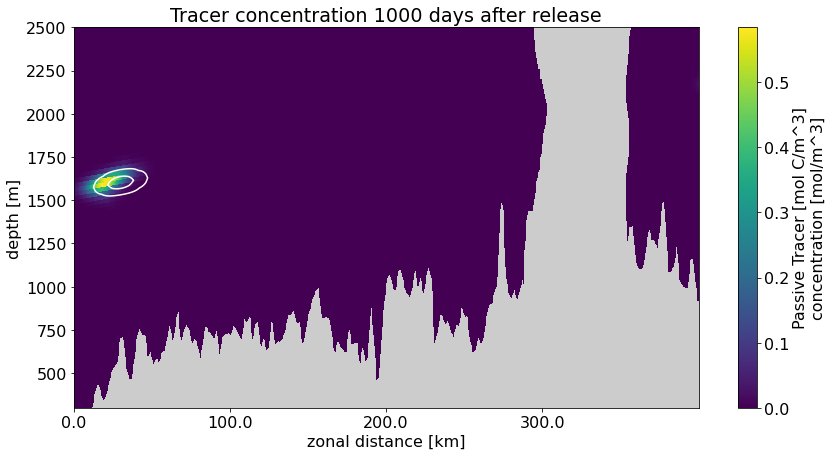

In [10]:
plt.figure(figsize=(14,7))
plt.subplot(1,1,1, facecolor=(0.8, 0.8, 0.8))
ds['TRAC01'] = ds['TRAC01'].where(ds['TRAC01'] != 0.)
ds['TRAC01'].isel(time=-1).plot(y='Zr', x='Xr')
plt.contour(ds['TRAC01'].Xr.values, ds['TRAC01'].Zr.values, C1.values.squeeze(), colors='w', levels=[0.05, 0.5])
plt.ylim([300, 2500])
plt.xticks(np.arange(0,4,1)*1.e5, np.arange(0,4,1)*1.e2)
plt.xlabel("zonal distance [km]")
plt.ylabel("depth [m]")
plt.title("Tracer concentration 1000 days after release")

Text(0.5, 1.0, 'Tracer concentration 1000 days after release')

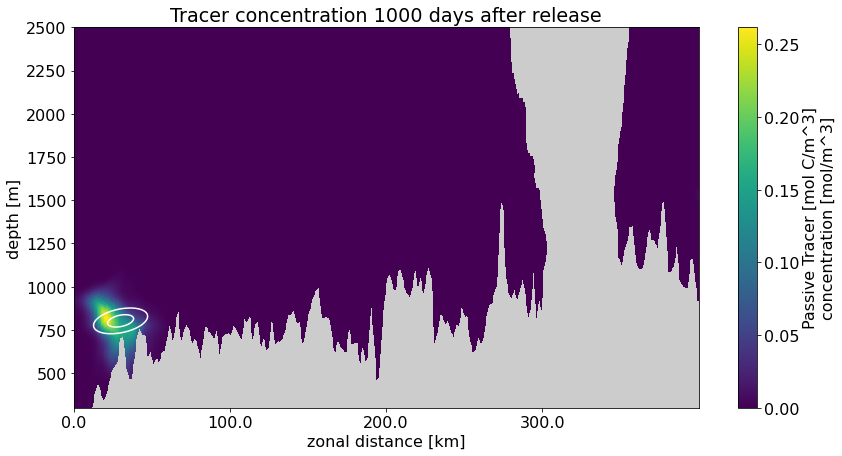

In [11]:
plt.figure(figsize=(14,7))
plt.subplot(1,1,1, facecolor=(0.8, 0.8, 0.8))
ds['TRAC02'] = ds['TRAC02'].where(ds['TRAC02'] != 0.)
ds['TRAC02'].isel(time=-1).plot(y='Zr', x='Xr')
plt.contour(ds['TRAC02'].Xr.values, ds['TRAC02'].Zr.values, C2.values.squeeze(), colors='w', levels=[0.05, 0.5])
plt.ylim([300, 2500])
plt.xticks(np.arange(0,4,1)*1.e5, np.arange(0,4,1)*1.e2)
plt.xlabel("zonal distance [km]")
plt.ylabel("depth [m]")
plt.title("Tracer concentration 1000 days after release")

Text(0.5, 1.0, 'Tracer concentration 100 days after release')

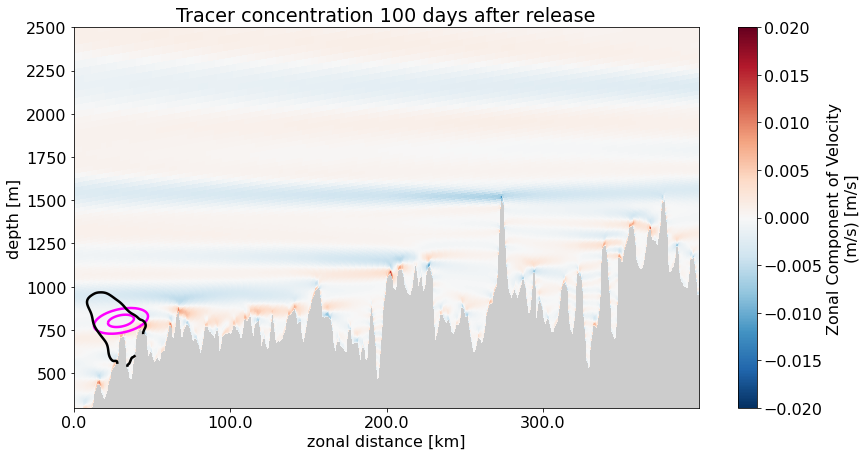

In [14]:
plt.figure(figsize=(14,7))
plt.subplot(1,1,1, facecolor=(0.8, 0.8, 0.8))
ds['UVEL'] = ds['UVEL'].where(ds['UVEL'] != 0.)
q = ds['UVEL'].isel(time=-1).plot(x='Xr_U', y='Zr_U')
q.set_clim([-2.e-2,2.e-2])
plt.contour(ds['TRAC02'].Xr.values, ds['TRAC02'].Zr.values, C2.values.squeeze(), colors='magenta', linewidths = 2.5, levels=[0.05, 0.5])
plt.contour(ds['TRAC02'].Xr.values, ds['TRAC02'].Zr.values, np.transpose(ds['TRAC02'].isel(time=-1).squeeze().values), colors='k', linewidths = 2.5, levels=[0.05, 0.5])
plt.ylim([300, 2500])
plt.xticks(np.arange(0,4,1)*1.e5, np.arange(0,4,1)*1.e2)
plt.xlabel("zonal distance [km]")
plt.ylabel("depth [m]")
plt.title("Tracer concentration 100 days after release")

Text(0.5, 1.0, 'Tracer concentration 100 days after release')

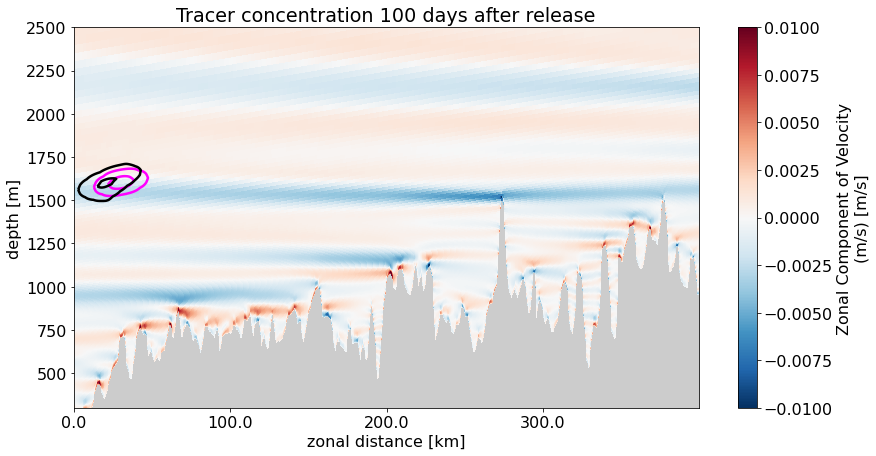

In [15]:
plt.figure(figsize=(14,7))
plt.subplot(1,1,1, facecolor=(0.8, 0.8, 0.8))
ds['UVEL'] = ds['UVEL'].where(ds['UVEL'] != 0.)
q = ds['UVEL'].isel(time=-1).plot(x='Xr_U', y='Zr_U')
q.set_clim([-1.e-2,1.e-2])
plt.contour(ds['TRAC01'].Xr.values, ds['TRAC01'].Zr.values, C1.values.squeeze(), colors='magenta', linewidths = 2.5, levels=[0.05, 0.5])
plt.contour(ds['TRAC01'].Xr.values, ds['TRAC01'].Zr.values, np.transpose(ds['TRAC01'].isel(time=-1).squeeze().values), colors='k', linewidths = 2.5, levels=[0.05, 0.5])
plt.ylim([300, 2500])
plt.xticks(np.arange(0,4,1)*1.e5, np.arange(0,4,1)*1.e2)
plt.xlabel("zonal distance [km]")
plt.ylabel("depth [m]")
plt.title("Tracer concentration 100 days after release")